# Phenotypes prediction from SNPs data

The dataset contains a set of SNPs (coded as -1/0/1) and a set of phenotypes averaged across locations for a Mesoamerican Diversity Panel (MDP) data of common bean. The SNPs data were converted in a hdf5 format for making the File I/O faster

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [2]:
# read genotype data
final_SNPs = pd.read_hdf('data/BeanCAP_MDP_genotype_data.hdf5', 'snptable')
final_SNPs.head()

,Chr01_97670,Chr01_97701,Chr01_97716,Chr01_97721,Chr01_97808,Chr01_98768,Chr01_98935,Chr01_99285,Chr01_103581,Chr01_103625,...,sc09737ln2051_933_A_G_469467397,sc09754ln2049_872_A_C_469502176,sc09833ln2034_1171_G_A_469663747,sc09833ln2034_399_C_T_469662975,sc09867ln2028_610_C_T_469732277,sc09915ln2022_1787_A_G_469830647,sc09947ln2017_1192_A_G_469894659,sc10003ln2009_1678_C_A_470007833,sc10021ln2001_533_T_C_470042786,sc10022ln2002_1089_C_T_470045343
0,-1,-1,-1,-1,-1,1,1,1,-1,1,...,1,-1,-1,-1,1,1,-1,-1,-1,1
1,-1,-1,-1,-1,-1,1,1,1,-1,1,...,1,-1,-1,-1,1,1,-1,-1,-1,1
2,-1,-1,-1,-1,-1,1,1,1,-1,1,...,1,-1,-1,-1,1,-1,1,-1,-1,1
3,-1,-1,-1,-1,-1,1,1,1,-1,-1,...,1,-1,1,1,1,1,-1,-1,1,1
4,-1,-1,-1,-1,-1,1,1,-1,-1,1,...,1,-1,-1,-1,1,-1,-1,-1,-1,1


In [3]:
# read all phenotype data
pheno_data = pd.read_csv('data/Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt', 
                         sep='\t', header=0)
pheno_data.head()

,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


## Averaged data across locations
For a preliminary understanding of the feasibility of the approach and the best alogirhtms I will first use days to flowering (DF) and days to maturity (DM) averaged across all the locations. I will compare thre different regression models for this analysis. Since the ElasticNet and Lasso are more sensitive to hyper-parameters optimization I will use a 10 fold cross-validation on the train set for those two algorithms. Instead for the R
#### Days to flowering (DF)

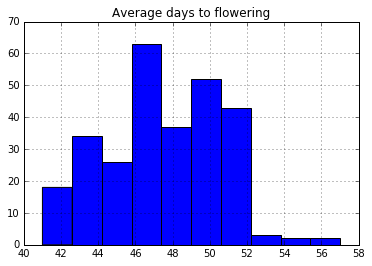

In [4]:
# extract flowering time
df_avg = pheno_data['df']
df_avg.hist()
plt.title('Average days to flowering')
plt.show()

In [5]:
# prepare data for machine learning
X = final_SNPs.values
y = df_avg.values

# create train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20, random_state=101)
print(np.shape(X_train), np.shape(X_test))

# prepar EMPTY lists of values for DF
MAE=[]
R2=[]
PCC=[]

(224, 243623) (56, 243623)


In [6]:
# use ElasticNetCV
from sklearn.linear_model import ElasticNetCV

EN_CV = ElasticNetCV(l1_ratio=[.1, .25, .5, .75, .9, .99], n_alphas = 100, 
                     alphas = np.logspace(-4, 2, 7, base=2), 
                     eps = np.logspace(-4, 2, 7, base=2),
                     max_iter=1000, n_jobs=4, cv = 10, random_state=101, 
                     selection='random', tol = 0.0001)

# fit the model
EN_CV.fit(X_train, y_train)
y_pred = EN_CV.predict(X_test)
# append result for final comparison
MAE.append(mean_absolute_error(y_test, y_pred))
R2.append(r2_score(y_test, y_pred))
PCC.append(pearsonr(y_test, y_pred)[0])

In [7]:
# use LassoCV
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(n_alphas = 100, alphas = np.logspace(-4, 2, 7, base=2), 
                   eps = np.logspace(-4, 2, 7, base=2),
                   max_iter=1000, n_jobs=4, cv = 10, random_state=101 )
lasso_cv.fit(X_train, y_train)
y_pred = lasso_cv.predict(X_test)
MAE.append(mean_absolute_error(y_test, y_pred))
R2.append(r2_score(y_test, y_pred))
PCC.append(pearsonr(y_test, y_pred)[0])

In [8]:
# use the random forest approach
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 10000, max_features='sqrt',
                          n_jobs=4, random_state = 101)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
MAE.append(mean_absolute_error(y_test, y_pred))
R2.append(r2_score(y_test, y_pred))
PCC.append(pearsonr(y_test, y_pred)[0])

In [9]:
DF_prediction=pd.DataFrame({'MAE': MAE, 'R2': R2, 'PCC':PCC}, columns=['MAE', 'R2', 'PCC'], 
                           index=['Elastic Net', 'LASSO', 'Random Forest'])
DF_prediction

,MAE,R2,PCC
Elastic Net,1.303729,0.596259,0.790383
LASSO,1.368053,0.562620,0.770861
Random Forest,1.247762,0.647410,0.816749


Even without hyperparameters optimization the RandomForest algorithms seems to perform slightly better that the other two. Let's how these algorithms will work on days to maturity!!
#### Days to maturity (DM)

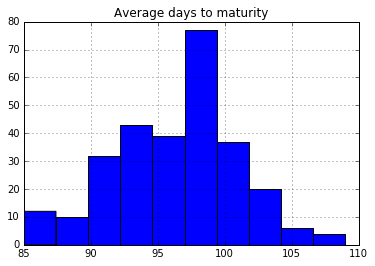

In [10]:
# extract flowering time
dm_avg = pheno_data['dm']
dm_avg.hist()
plt.title('Average days to maturity')
plt.show()

In [11]:
# prepare data for machine learning (again, just for being sure the same data are used)
X = final_SNPs.values
y = dm_avg.values

# create train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20, random_state=101)
print(np.shape(X_train), np.shape(X_test))

# prepar EMPTY lists of values for DF
MAE=[]
R2=[]
PCC=[]

(224, 243623) (56, 243623)


In [12]:
# use ElasticNetCV
from sklearn.linear_model import ElasticNetCV

EN_CV = ElasticNetCV(l1_ratio=[.1, .25, .5, .75, .9, .99], n_alphas = 100, 
                     alphas = np.logspace(-4, 2, 7, base=2), 
                     eps = np.logspace(-4, 2, 7, base=2),
                     max_iter=1000, n_jobs=4, cv = 10, random_state=101, 
                     selection='random', tol = 0.0001)

# fit the model
EN_CV.fit(X_train, y_train)
y_pred = EN_CV.predict(X_test)
# append result for final comparison
MAE.append(mean_absolute_error(y_test, y_pred))
R2.append(r2_score(y_test, y_pred))
PCC.append(pearsonr(y_test, y_pred)[0])

In [13]:
# use LassoCV
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(n_alphas = 100, alphas = np.logspace(-4, 2, 7, base=2), 
                   eps = np.logspace(-4, 2, 7, base=2),
                   max_iter=1000, n_jobs=4, cv = 10, random_state=101 )
lasso_cv.fit(X_train, y_train)
y_pred = lasso_cv.predict(X_test)
MAE.append(mean_absolute_error(y_test, y_pred))
R2.append(r2_score(y_test, y_pred))
PCC.append(pearsonr(y_test, y_pred)[0])

In [14]:
# use the random forest approach
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 10000, max_features='sqrt',
                          n_jobs=4, random_state = 101)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
MAE.append(mean_absolute_error(y_test, y_pred))
R2.append(r2_score(y_test, y_pred))
PCC.append(pearsonr(y_test, y_pred)[0])

In [15]:
DM_prediction=pd.DataFrame({'MAE': MAE, 'R2': R2, 'PCC':PCC}, columns=['MAE', 'R2', 'PCC'], 
                           index=['Elastic Net', 'LASSO', 'Random Forest'])
DM_prediction

,MAE,R2,PCC
Elastic Net,2.919425,0.162812,0.456494
LASSO,3.356798,-0.015226,0.362317
Random Forest,2.955407,0.208676,0.491529
